[View in Colaboratory](https://colab.research.google.com/github/AshwiniBaipadithayaMadhusudan/MNIST-DIGIT-PREDICTION/blob/master/DigitRecognizerNN.ipynb)

**MOUNTING DRIVE:**

---


Firstly, we will mount the drive so that we can access drive from colab to read and write files.


In [0]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!wget https://launchpad.net/~alessandro-strada/+archive/ubuntu/google-drive-ocamlfuse-beta/+build/15331130/+files/google-drive-ocamlfuse_0.7.0-0ubuntu1_amd64.deb
!dpkg -i google-drive-ocamlfuse_0.7.0-0ubuntu1_amd64.deb
!apt-get install -f
!apt-get -y install -qq fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

In [0]:
!mkdir -p drive
!google-drive-ocamlfuse drive

**INSTALLING FASTAI LIBRARY:**

---



In [0]:
!pip install fastai==0.7.0 # 0.7.0 is used to install the latest version of fastai
from fastai.imports import *
from fastai.torch_imports import *
from fastai.io import *
%matplotlib inline

from fastai.metrics import *
from fastai.model import *
from fastai.dataset import *

import torch.nn as nn

**DOWNLOAD AND READ DATA:**

---
The MNIST data is downloaded from web and saved in pickle format


In [0]:
PATH="/content/drive/MNIST/" #set the path to the folder where the input file is stored

In [0]:
URL='http://deeplearning.net/data/mnist/'
FILENAME='mnist.pkl.gz'

def load_mnist(filename):
    return pickle.load(gzip.open(filename, 'rb'), encoding='latin-1')#opens the zipped pickle file

In [0]:
get_data(URL+FILENAME, PATH+FILENAME)#copies the file fom URL to path specified
((x, y), (x_valid, y_valid), _) = load_mnist(PATH+FILENAME)#reads and loads the file

#Note that we have used underscore in the place of test file above . This is because we do not want to store test file

In [0]:
type(x), x.shape, type(y), y.shape # There are 50000 images in both train and validation sets. Each image is 28*28(784) pixels

In [0]:
!ls {PATH}#This is used to list all the files in the specified path. Note that PATH is written inside curly braces. 
          #This is because ls is a bash command.

**NORMALIZE THE DATA**

---


In [6]:
mean = x.mean()
std = x.std()

x=(x-mean)/std              #It is important that we normalize data whenever we choose Neural networks. This is because we use gradient descent as
                            # our optimizer. If the data is normalized, it will reach it optima faster.
mean, std, x.mean(), x.std()

(0.13044983, 0.3072898, -3.1638146e-07, 0.99999934)

In [0]:
x_valid = (x_valid-mean)/std  #Always validation and test data should be normalized using mean and std of training data
x_valid.mean(), x_valid.std()

**FIT THE NEURAL NETWORK MODEL AND FIND BEST FIT PARAMETERS**

---



In [0]:
net = nn.Sequential(
    nn.Linear(28*28, 100), 
    nn.ReLU(),
    nn.Linear(100, 100),
    nn.ReLU(),
    nn.Linear(100, 10),
    nn.LogSoftmax()            
).cuda()                       # cuda() will run the model on GPU  

In [0]:
md = ImageClassifierData.from_arrays(PATH, (x,y), (x_valid, y_valid))

In [0]:
loss=nn.NLLLoss()      # Loss fuction used is negative log likelihood loss
metrics=[accuracy]

opt=optim.SGD(net.parameters(), 1e-1, momentum=0.9, weight_decay=1e-3)# Parameters of Loss function will be optimized using
                                                                      # Stochastic gradient descent

In [0]:
fit(net, md, n_epochs=5, crit=loss, opt=opt, metrics=metrics) # We will train 'net' model with 'md' data.Now we will calculate negative log
                                                              #likelihood loss. We try to minimize this loss by finding best parameters with minimum
                                                              # loss. This is done using SGD . 5 epoch means optimizer will try to optimize for 
                                                              # 5*(no_of_rows in md)

In [0]:
set_lrs(opt, 1e-2)# This will change the weight decay. Weight decay is used to determine the amount to which we want use regularization

In [0]:
fit(net, md, n_epochs=3, crit=loss, opt=opt, metrics=metrics)

In [0]:
t = [o.numel() for o in net.parameters()]
t, sum(t)

**PREDICT VALIDATION DATA**

---



In [0]:
preds = predict(net, md.val_dl)

In [0]:
preds.shape

In [0]:
preds.argmax(axis=1)[:5]

In [0]:
np.mean(preds == y_valid)          #accuracy on validation set

In [0]:
def plots(ims, figsize=(12,6), rows=2, titles=None):
    f = plt.figure(figsize=figsize)
    cols = len(ims)//rows
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i], cmap='gray')

In [0]:
x_imgs = np.reshape(x_valid, (-1,28,28))

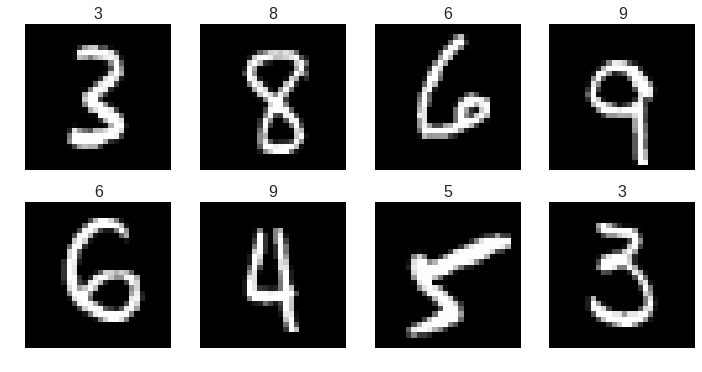

In [29]:
plots(x_imgs[:8], titles=preds[:8])# plotting the predictions on first 8 validation data and their actual values as titles